In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import cv2

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

#init_notebook_mode(connected=True)
RANDOM_SEED = 42

In [ ]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
train_dir = '/content/drive/My Drive/Dataset_200/dataset/train/'
test_dir = '/content/drive/My Drive/Dataset_200/dataset/test/'
validation_dir = '/content/drive/My Drive/Dataset_200/dataset/validation/'

In [ ]:
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(train_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)
X_val, y_val, _ = load_data(validation_dir, IMG_SIZE)

100%|██████████| 2/2 [16:37<00:00, 498.60s/it]


1536 images loaded from /content/drive/My Drive/Dataset_200/dataset/train/ directory.


100%|██████████| 2/2 [05:03<00:00, 151.58s/it]


480 images loaded from /content/drive/My Drive/Dataset_200/dataset/test/ directory.


100%|██████████| 2/2 [04:03<00:00, 121.79s/it]

384 images loaded from /content/drive/My Drive/Dataset_200/dataset/validation/ directory.


In [ ]:
X_train.shape

(1536, 227, 227, 3)

In [ ]:
input_shape = (224,224, 3)
batch_size = 32

In [ ]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

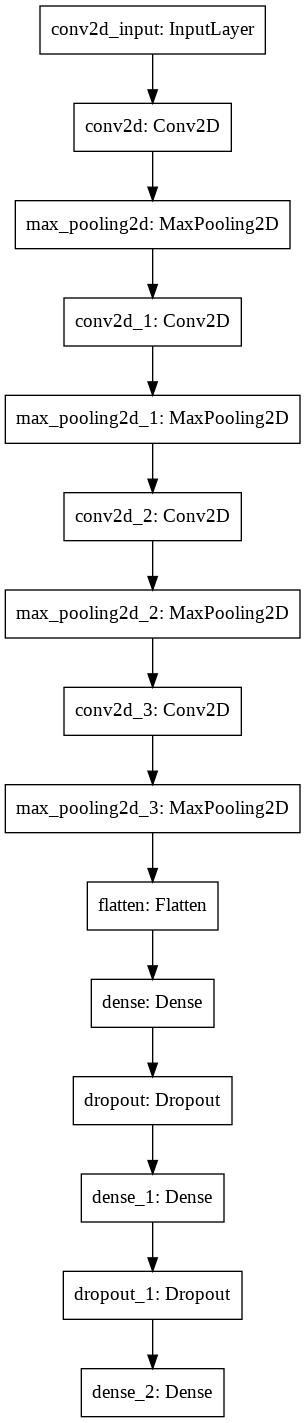

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

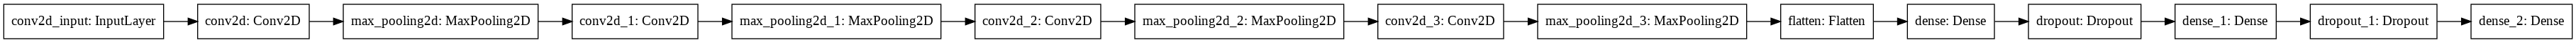

In [ ]:
plot_model(model, to_file='model.png', rankdir='LR')

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
EPOCHS = 50
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=10
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[es]
)

Epoch 1/50
48/48 [==============================] - 41s 205ms/step - loss: 0.6783 - accuracy: 0.5469 - val_loss: 0.6461 - val_accuracy: 0.5807
Epoch 2/50
48/48 [==============================] - 10s 203ms/step - loss: 0.6141 - accuracy: 0.6764 - val_loss: 0.5389 - val_accuracy: 0.7839
Epoch 3/50
48/48 [==============================] - 10s 201ms/step - loss: 0.5525 - accuracy: 0.7161 - val_loss: 0.4921 - val_accuracy: 0.7943
Epoch 4/50
48/48 [==============================] - 10s 202ms/step - loss: 0.5142 - accuracy: 0.7507 - val_loss: 0.4447 - val_accuracy: 0.8099
Epoch 5/50
48/48 [==============================] - 10s 202ms/step - loss: 0.4712 - accuracy: 0.7943 - val_loss: 0.4341 - val_accuracy: 0.7943
Epoch 6/50
48/48 [==============================] - 10s 201ms/step - loss: 0.4566 - accuracy: 0.7975 - val_loss: 0.3973 - val_accuracy: 0.8490
Epoch 7/50
48/48 [==============================] - 10s 201ms/step - loss: 0.4239 - accuracy: 0.8210 - val_loss: 0.3970 - val_accuracy: 0.8385

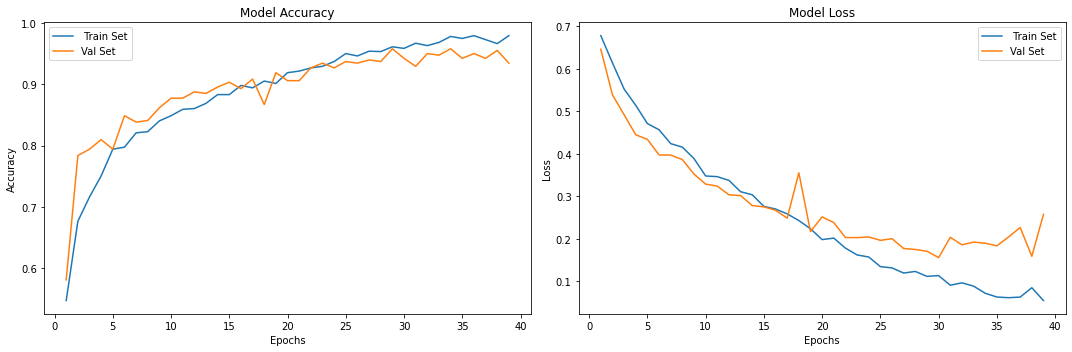

In [ ]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# validate on test set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9616, Val: 0.9193
Validation Accuracy = 0.9193
Precision: 0.987879
Recall: 0.848958
F1 score: 0.913165
Cohens kappa: 0.838542
ROC AUC: 0.919271
[[190   2]
 [ 29 163]]
True positive: 163 , True negative: 190 , False positive: 2 , False negative: 29


In [ ]:
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9616, Test: 0.9062
Test Accuracy = 0.9062
Precision: 0.966507
Recall: 0.841667
F1 score: 0.899777
Cohens kappa: 0.812500
ROC AUC: 0.906250
[[233   7]
 [ 38 202]]
True positive: 202 , True negative: 233 , False positive: 7 , False negative: 38


In [1]:
tp = 202
tn = 233
fp = 7
fn = 38
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

Sensitivity: 0.8417
Specificity: 0.9708
